<a href="https://colab.research.google.com/github/athabrani/DeepLearning/blob/main/PyTorch_SVHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.amp import GradScaler, autocast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))  # Normalization for SVHN
])

train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

#CNN Model

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [41]:
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.to(device)
    scaler = GradScaler()  # GradScaler for mixed precision training
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast(device_type=device):  # Mixed precision enabled
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        scheduler.step(epoch_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Metrics -> Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


    return epoch_loss, epoch_accuracy


In [53]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            y_prob.extend(F.softmax(outputs, dim=1).cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    auc = roc_auc_score(np.eye(10)[y_true], np.array(y_prob), average='macro', multi_class='ovr')

    print(f"Test Metrics -> Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")


    return acc, precision, recall, f1, y_true, y_pred


In [47]:
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)


train_loss, train_acc = train_model(cnn, train_loader, criterion, optimizer, epochs=10)
val_acc, val_precision, val_recall, val_f1 = evaluate_model(cnn, test_loader)
print(f"Final Evaluation -> Val Acc: {val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")


Epoch 1/10, Train Metrics -> Loss: 0.8920, Accuracy: 0.7216
Epoch 2/10, Train Metrics -> Loss: 0.4424, Accuracy: 0.8731
Epoch 3/10, Train Metrics -> Loss: 0.3496, Accuracy: 0.8981
Epoch 4/10, Train Metrics -> Loss: 0.2865, Accuracy: 0.9165
Epoch 5/10, Train Metrics -> Loss: 0.2374, Accuracy: 0.9300
Epoch 6/10, Train Metrics -> Loss: 0.1950, Accuracy: 0.9430
Epoch 7/10, Train Metrics -> Loss: 0.1607, Accuracy: 0.9532
Epoch 8/10, Train Metrics -> Loss: 0.1305, Accuracy: 0.9605
Epoch 9/10, Train Metrics -> Loss: 0.1010, Accuracy: 0.9694
Epoch 10/10, Train Metrics -> Loss: 0.0816, Accuracy: 0.9754
Test Metrics -> Accuracy: 0.8816, Precision: 0.8754, Recall: 0.8668, F1: 0.8687, AUC: 0.9866
Final Evaluation -> Val Acc: 0.8816, Precision: 0.8754, Recall: 0.8668, F1: 0.8687


Test Accuracy: 0.8816072526121697
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1744
           1       0.91      0.94      0.93      5099
           2       0.91      0.93      0.92      4149
           3       0.87      0.82      0.84      2882
           4       0.88      0.90      0.89      2523
           5       0.87      0.88      0.88      2384
           6       0.87      0.81      0.84      1977
           7       0.90      0.89      0.90      2019
           8       0.92      0.76      0.83      1660
           9       0.70      0.89      0.79      1595

    accuracy                           0.88     26032
   macro avg       0.88      0.87      0.87     26032
weighted avg       0.88      0.88      0.88     26032



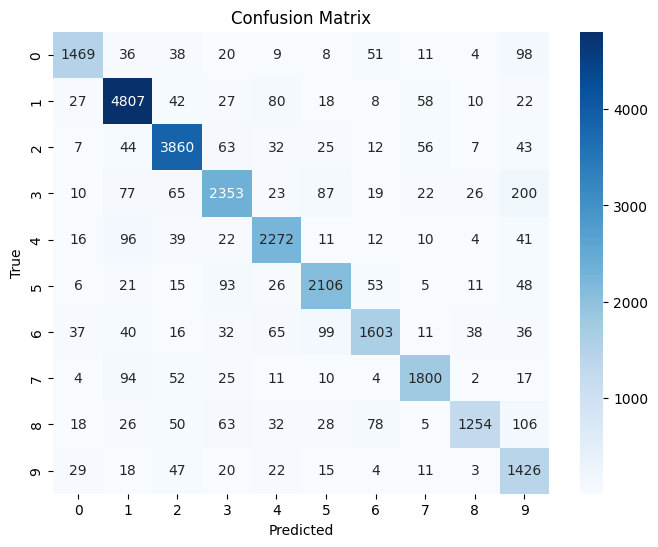

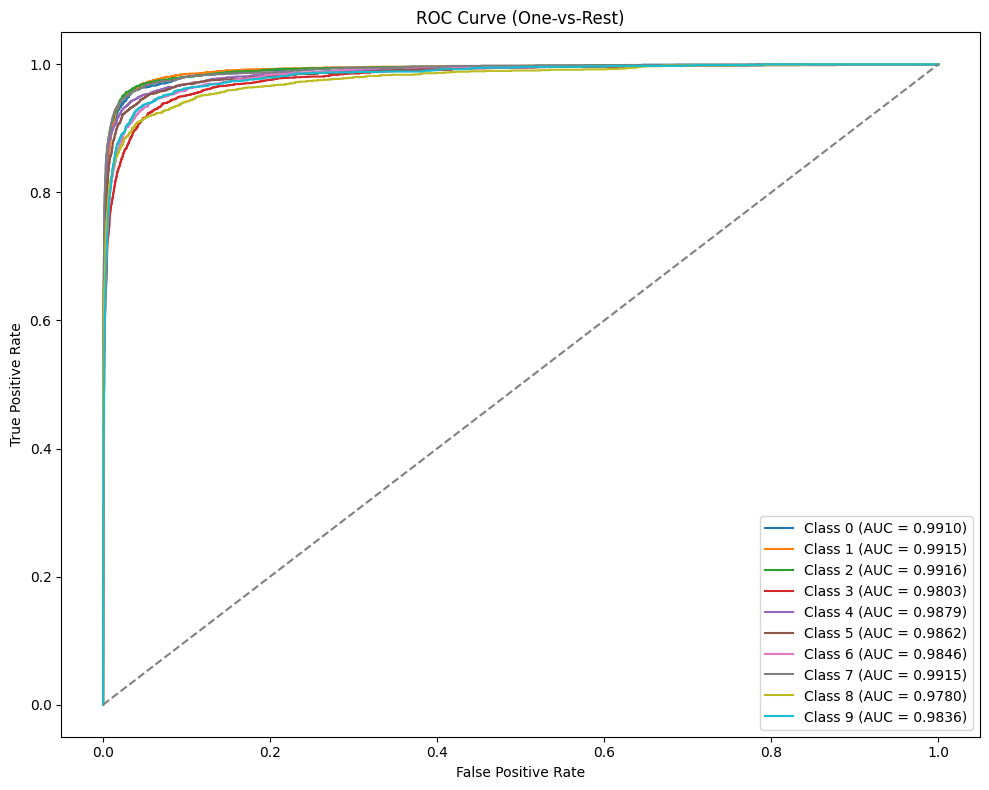

In [50]:
cnn.eval()

all_probs = []
all_targets = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = cnn(inputs)
        probs = torch.softmax(outputs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_targets.append(labels.cpu().numpy())
        all_preds.append(torch.argmax(probs, dim=1).cpu().numpy())

# Gabungkan semua hasil batch
preds_prob = np.concatenate(all_probs, axis=0)
targets = np.concatenate(all_targets, axis=0)
preds = np.concatenate(all_preds, axis=0)

# Evaluasi dasar
print("Test Accuracy:", (preds == targets).mean())
print(classification_report(targets, preds))

# One-hot encode target
targets_bin = label_binarize(targets, classes=range(10))

# ROC Curve & AUC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(targets_bin[:, i], preds_prob[:, i])
    roc_auc[i] = roc_auc_score(targets_bin[:, i], preds_prob[:, i])

# Confusion Matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(targets, preds)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve Plot
output_size = 10
plt.figure(figsize=(10, 8))
for i in range(output_size):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.tight_layout()
plt.show()

#MLP Model

In [19]:
class FlattenedSVHN(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        image, label = self.dataset[index]
        image = image.view(-1)  # Flatten the image (3*32*32 = 3072)
        return image, label

    def __len__(self):
        return len(self.dataset)

train_dataset_mlp = FlattenedSVHN(train_dataset)
val_dataset_mlp = FlattenedSVHN(val_dataset)
test_dataset_mlp = FlattenedSVHN(test_dataset)

train_loader_mlp = DataLoader(train_dataset_mlp, batch_size=128, shuffle=True)
val_loader_mlp = DataLoader(val_dataset_mlp, batch_size=128, shuffle=False)
test_loader_mlp = DataLoader(test_dataset_mlp, batch_size=128, shuffle=False)

In [20]:
class MLP(nn.Module):
    def __init__(self, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 2048), nn.ReLU(), nn.BatchNorm1d(2048),
            nn.Linear(2048, 1024), nn.ReLU(), nn.BatchNorm1d(1024),
            nn.Linear(1024, 512), nn.ReLU(), nn.BatchNorm1d(512),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.3), nn.BatchNorm1d(256),
            nn.Linear(256, output_size)  # No softmax, handled by CrossEntropyLoss
        )

    def forward(self, x):
        return self.layers(x)

In [48]:
mlp = MLP(output_size=10)
criterion_mlp = nn.CrossEntropyLoss()
optimizer_mlp = optim.Adam(mlp.parameters(), lr=0.001)

for epoch in range(10):
    train_loss, train_acc = train_model(mlp, train_loader, criterion_mlp, optimizer_mlp, epochs=1)
    val_acc, val_precision, val_recall, val_f1 = evaluate_model(mlp, test_loader)
    print(f"[MLP] Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")



Epoch 1/1, Train Metrics -> Loss: 1.4207, Accuracy: 0.5206
Test Metrics -> Accuracy: 0.6310, Precision: 0.6183, Recall: 0.5853, F1: 0.5928, AUC: 0.9132
[MLP] Epoch 1: Train Acc = 0.5206, Val Acc = 0.6310
Epoch 1/1, Train Metrics -> Loss: 0.9351, Accuracy: 0.7013
Test Metrics -> Accuracy: 0.6901, Precision: 0.6739, Recall: 0.6672, F1: 0.6666, AUC: 0.9391
[MLP] Epoch 2: Train Acc = 0.7013, Val Acc = 0.6901
Epoch 1/1, Train Metrics -> Loss: 0.7779, Accuracy: 0.7531
Test Metrics -> Accuracy: 0.7437, Precision: 0.7271, Recall: 0.7221, F1: 0.7229, AUC: 0.9562
[MLP] Epoch 3: Train Acc = 0.7531, Val Acc = 0.7437
Epoch 1/1, Train Metrics -> Loss: 0.6896, Accuracy: 0.7824
Test Metrics -> Accuracy: 0.7505, Precision: 0.7544, Recall: 0.7181, F1: 0.7310, AUC: 0.9578
[MLP] Epoch 4: Train Acc = 0.7824, Val Acc = 0.7505
Epoch 1/1, Train Metrics -> Loss: 0.6123, Accuracy: 0.8073
Test Metrics -> Accuracy: 0.7742, Precision: 0.7596, Recall: 0.7525, F1: 0.7547, AUC: 0.9646
[MLP] Epoch 5: Train Acc = 0.807

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp.to(device)  # Ensure the model is on the correct device

MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=2048, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=1024, out_features=512, bias=True)
    (8): ReLU()
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=512, out_features=256, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.3, inplace=False)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [55]:
test_acc_mlp, precision_mlp, recall_mlp, f1_mlp, targets_mlp, preds_mlp = evaluate_model(mlp, test_loader_mlp)

print("MLP Test Accuracy:", test_acc_mlp)
print(f"Precision: {precision_mlp:.4f}, Recall: {recall_mlp:.4f}, F1 Score: {f1_mlp:.4f}")
print(classification_report(targets_mlp, preds_mlp))


Test Metrics -> Accuracy: 0.8084, Precision: 0.7974, Recall: 0.7915, F1: 0.7932, AUC: 0.9737
MLP Test Accuracy: 0.8083512599877074
Precision: 0.7974, Recall: 0.7915, F1 Score: 0.7932
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1744
           1       0.83      0.90      0.86      5099
           2       0.87      0.85      0.86      4149
           3       0.79      0.69      0.74      2882
           4       0.82      0.86      0.84      2523
           5       0.80      0.78      0.79      2384
           6       0.81      0.73      0.77      1977
           7       0.80      0.83      0.82      2019
           8       0.75      0.74      0.74      1660
           9       0.69      0.78      0.73      1595

    accuracy                           0.81     26032
   macro avg       0.80      0.79      0.79     26032
weighted avg       0.81      0.81      0.81     26032



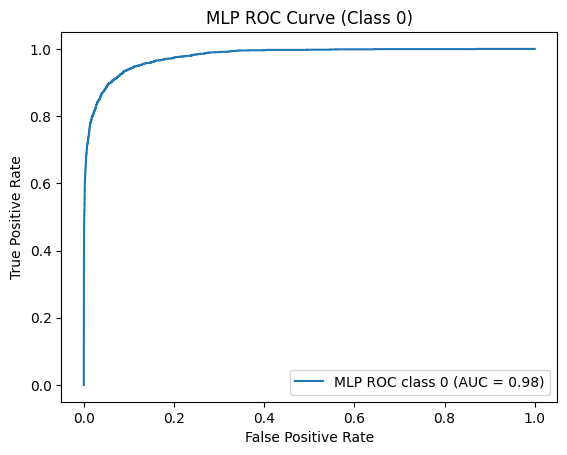

In [59]:
# Ensure the model is on the correct device
mlp.eval()

# List to store the predicted probabilities
all_probs_mlp = []

with torch.no_grad():
    for x, _ in test_loader_mlp:
        # Move input tensor to the same device as the model
        x = x.to(device)  # `device` is the same as the one used for the model

        # Get prediction probabilities
        prob = F.softmax(mlp(x), dim=1)
        all_probs_mlp.append(prob)

# Concatenate the probabilities and convert to numpy
all_probs_mlp = torch.cat(all_probs_mlp).cpu().numpy()  # Ensure it's moved back to CPU

# ROC & AUC per class
fpr_mlp = dict()
tpr_mlp = dict()
roc_auc_mlp = dict()

for i in range(10):
    fpr_mlp[i], tpr_mlp[i], _ = roc_curve(targets_bin_mlp[:, i], all_probs_mlp[:, i])
    roc_auc_mlp[i] = roc_auc_score(targets_bin_mlp[:, i], all_probs_mlp[:, i])

# Plot the ROC Curve for class 0
plt.plot(fpr_mlp[0], tpr_mlp[0], label=f'MLP ROC class 0 (AUC = {roc_auc_mlp[0]:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("MLP ROC Curve (Class 0)")
plt.show()


##  Perbandingan Matriks Evaluasi

Berikut adalah hasil evaluasi performa dari dua model (MLP dan CNN) terhadap data pengujian:

| Metric           | MLP    | CNN    |
|------------------|--------|--------|
| Akurasi          | 0.8084 | 0.8816 |
| Presisi          | 0.7974 | 0.8754 |
| Recall           | 0.7915 | 0.8668 |
| F1 Score         | 0.7932 | 0.8687 |
| AUC (Macro)      | 0.9737 | 0.9866 |

---

##  Analisis Perbandingan

### Akurasi (Accuracy)

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

Akurasi mengukur seberapa besar proporsi prediksi yang benar terhadap seluruh data.  
Model CNN mencatat akurasi lebih tinggi (88.16%) dibandingkan dengan MLP (80.84%), menandakan CNN lebih baik dalam mengenali pola dalam data SVHN.

---

### Presisi (Precision)

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Presisi menunjukkan seberapa tepat model dalam memprediksi kelas positif.  
CNN memiliki presisi lebih tinggi (87.54%) dibandingkan MLP (79.74%), yang berarti prediksi CNN cenderung lebih akurat untuk tiap kelas.

---

### Recall (Sensitivity)

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Recall mengukur kemampuan model dalam mendeteksi seluruh instance dari kelas yang relevan.  
CNN mencetak recall lebih tinggi (86.68%) dibandingkan MLP (79.15%), menunjukkan kemampuannya lebih baik dalam menangkap data yang seharusnya diklasifikasi sebagai positif.

---

### F1 Score

$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

F1 Score adalah rata-rata harmonik dari precision dan recall.  
CNN mencatat skor F1 lebih tinggi (86.87%) dibandingkan MLP (79.32%), memperlihatkan performa lebih seimbang dan solid dalam klasifikasi.

---

### AUC (Area Under Curve)

AUC mengukur kemampuan model membedakan antar kelas.  
Nilai AUC CNN (0.9866) lebih tinggi dari MLP (0.9737), mengindikasikan CNN memiliki kemampuan klasifikasi yang lebih baik dan stabil di semua kelas.

---

##  Evaluasi Per Kelas

### MLP - Laporan Klasifikasi

| Kelas | Precision | Recall | F1 Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.83      | 0.75   | 0.79     | 1744    |
| 1     | 0.83      | 0.90   | 0.86     | 5099    |
| 2     | 0.87      | 0.85   | 0.86     | 4149    |
| 3     | 0.79      | 0.69   | 0.74     | 2882    |
| 4     | 0.82      | 0.86   | 0.84     | 2523    |
| 5     | 0.80      | 0.78   | 0.79     | 2384    |
| 6     | 0.81      | 0.73   | 0.77     | 1977    |
| 7     | 0.80      | 0.83   | 0.82     | 2019    |
| 8     | 0.75      | 0.74   | 0.74     | 1660    |
| 9     | 0.69      | 0.78   | 0.73     | 1595    |

### CNN - Laporan Klasifikasi

| Kelas | Precision | Recall | F1 Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.91      | 0.84   | 0.87     | 1744    |
| 1     | 0.91      | 0.94   | 0.93     | 5099    |
| 2     | 0.91      | 0.93   | 0.92     | 4149    |
| 3     | 0.87      | 0.82   | 0.84     | 2882    |
| 4     | 0.88      | 0.90   | 0.89     | 2523    |
| 5     | 0.87      | 0.88   | 0.88     | 2384    |
| 6     | 0.87      | 0.81   | 0.84     | 1977    |
| 7     | 0.90      | 0.89   | 0.90     | 2019    |
| 8     | 0.92      | 0.76   | 0.83     | 1660    |
| 9     | 0.70      | 0.89   | 0.79     | 1595    |

---

##  Kesimpulan Perbandingan Model

Model CNN secara konsisten mengungguli MLP pada seluruh metrik evaluasi.  
CNN menunjukkan akurasi tinggi (>88%), serta keseimbangan antara presisi, recall, dan F1 Score yang sangat baik.
